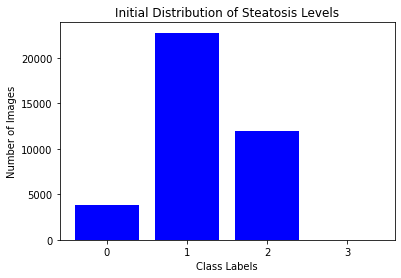

In [1]:
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.utils import plot_model

# Paths
data_dir = 'D:/DATASET/CNN/steatosis/train'  # Original dataset directory
balanced_data_dir = 'D:/DATASET/CNN/steatosis/balanced_data'  # Target directory for balanced dataset

# Create balanced_data directory and subdirectories for each class
os.makedirs(balanced_data_dir, exist_ok=True)
classes = ['0', '1', '2', '3']
for cls in classes:
    os.makedirs(os.path.join(balanced_data_dir, cls), exist_ok=True)

def count_images_in_directory(directory):
    """ Counts the images in each subdirectory of a given directory. """
    return {folder_name: len(os.listdir(os.path.join(directory, folder_name)))
            for folder_name in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder_name))}

# Count and plot initial distribution
initial_counts = count_images_in_directory(data_dir)

def plot_distribution(data, title):
    """ Plots the distribution of data classes. """
    classes = sorted(data.keys())
    counts = [data[cls] for cls in classes]
    plt.bar(classes, counts, color='blue')
    plt.xlabel('Class Labels')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.show()

plot_distribution(initial_counts, 'Initial Distribution of Steatosis Levels')

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


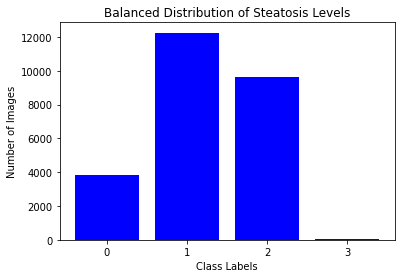

In [2]:
target_samples = 4000

# Data augmentation setup for oversampling
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def resample_class_images(class_id):
    """ Resamples images by class: oversampling or undersampling to target_samples. """
    class_dir = os.path.join(data_dir, class_id)
    target_dir = os.path.join(balanced_data_dir, class_id)
    images = os.listdir(class_dir)
    current_count = len(images)

    if current_count > target_samples:  # Undersampling
        selected_images = np.random.choice(images, target_samples, replace=False)
    else:  # Oversampling
        selected_images = images  # Include all original images
        # Augment data to reach target count
        augmentation_count = target_samples - current_count
        generator = datagen.flow_from_directory(
            directory=class_dir,
            target_size=(299, 299),
            batch_size=1,
            save_to_dir=target_dir,
            save_prefix='aug',
            save_format='jpeg'
        )
        for _ in range(augmentation_count):
            generator.next()

    # Copy selected images to balanced_data
    for img in selected_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(target_dir, img))

# Resample each class
for class_id in classes:
    resample_class_images(class_id)

# Count and plot balanced distribution
balanced_counts = count_images_in_directory(balanced_data_dir)
plot_distribution(balanced_counts, 'Balanced Distribution of Steatosis Levels')

In [ ]:
# Load ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Visualize the model architecture
plot_model(model, to_file='D:/DATASET/steatosis_model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Create a model for feature map extraction
feature_model = Model(inputs=base_model.input, outputs=base_model.get_layer('conv5_block3_out').output)

In [ ]:
def extract_and_display_image(image_path, feature_model):
    img = Image.open(image_path)
    img_resized = img.resize((299, 299), Image.ANTIALIAS)
    img_array = np.array(img_resized) / 255.0
    img_array = img_array[np.newaxis, ...]

    # Display the original image
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    # Get the feature maps
    feature_maps = feature_model.predict(img_array)[0]
    return feature_maps

In [ ]:
def visualize_feature_maps(feature_maps, num_features=15):
    # Display the first 'num_features' feature maps
    fig, axes = plt.subplots(nrows=int(np.sqrt(num_features)), ncols=int(np.sqrt(num_features)), figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i < num_features:
            ax.imshow(feature_maps[:, :, i], cmap='viridis')
            ax.axis('off')
    plt.show()

In [ ]:
# Prepare data generator for training
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    balanced_data_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

In [ ]:
# Train the model
history = model.fit(train_generator, epochs=10)

# Save the trained model
model.save('D:/DATASET/Models/model_steatosis.h5')

In [ ]:
import json

# Save the training history
with open('D:/DATASET/Models/steatosis_history.json', 'w') as file:
    json.dump(history.history, file)

In [ ]:
# Function to plot validation loss
def plot_validation_loss(history, model_name):
    plt.plot(history['val_loss'], label=f'{model_name} Validation Loss')
    plt.title(f'{model_name} Validation Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.show()

In [ ]:
# Plot validation loss for steatosis model
with open('D:/DATASET/Models/steatosis_history.json', 'r') as file:
    fibrosis_history = json.load(file)

plot_validation_loss(fibrosis_history, 'Steatosis')

In [ ]:
from PIL import Image

image_path = "D:/DATASET/CNN/steatosis/train/2/14_178_99.png"
feature_maps = extract_and_display_image(image_path, feature_model)
visualize_feature_maps(feature_maps)

In [ ]:
# Create a model for feature map extraction
feature_model = Model(inputs=base_model.input, outputs=base_model.get_layer('conv5_block3_3_conv').output)

In [ ]:
image_path = "D:/DATASET/CNN/steatosis/train/2/14_178_99.png"
feature_maps = extract_and_display_image(image_path, feature_model)
visualize_feature_maps(feature_maps)

In [ ]:
def predict_new_image(image_path, model_path='steatosis_classification_model.h5'):
    """ Load an image, preprocess it, and use a trained model to predict the steatosis level. """

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch
    img_array /= 255.0  # Normalize the image

    # Predict the steatosis level
    probabilities = model.predict(img_array)
    predicted_class = np.argmax(probabilities)

    # Show the image and the prediction
    plt.imshow(img)
    plt.title(f'Predicted Steatosis Level: {predicted_class}')
    plt.axis('off')
    plt.show()

    return predicted_class

In [ ]:
# Assuming you have a test image 
image_path = 'D:/DATASET/CNN/steatosis/train/2/5_42_24.png'
predicted_class = predict_new_image(image_path)

In [ ]:
def crop_and_predict_large_image(image_path, model_path):
    # Load the pre-trained model
    model = load_model(model_path)
    
    # Load the image
    img = Image.open(image_path)

    # Define crop size and step size for the original desired crop dimensions
    crop_width, crop_height = 185, 93
    model_input_size = (299, 299)  # Model's expected input size

    # Initialize a list to store scores and prepare for cropping
    scores = []
    num_rows = (img.height // crop_height)
    num_cols = (img.width // crop_width)
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 10))

    # Crop the image and predict for each crop
    for i in range(0, img.height - crop_height + 1, crop_height):
        for j in range(0, img.width - crop_width + 1, crop_width):
            crop = img.crop((j, i, j + crop_width, i + crop_height))
            crop = crop.resize(model_input_size)  # Resize the crop to match the model's input size
            crop_array = np.array(crop) / 255.0  # Normalize the image data
            crop_array = np.expand_dims(crop_array, axis=0)  # Add batch dimension

            # Predict the class and store the score
            prediction = model.predict(crop_array)
            predicted_class = np.argmax(prediction)
            scores.append(predicted_class)

            # Plot each crop
            ax_idx = (i // crop_height, j // crop_width)
            axs[ax_idx].imshow(crop)
            axs[ax_idx].title.set_text(f'Score: {predicted_class}')
            axs[ax_idx].axis('off')

    # Calculate the average score of all crops
    average_score = np.mean(scores)
    print(f'Average Steatosis Score for the image: {average_score:.2f}')

    # Show the large image with the average score
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.title(f'Large Image with Average Score: {average_score:.2f}')
    plt.axis('off')
    plt.show()

    return average_score

In [ ]:
model_path = 'D:/DATASET/Models/model_steatosis.h5'
image_path = "D:/scoring/Z_nc40x2.jpg"
average_steatosis_score = crop_and_predict_large_image(image_path, model_path)